In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

Take the MNIST dataset in the form which has been posted on iCorsi (MNIST.npz).

• Split both training and test data in the following way: 

1) all samples corresponding to target"8", 
2) all samples corresponding to target 4", 
3) all the rest. Now you have 6 datasets (train/8, train/4, train/rest, test/8, test/4, test/rest).

• The data corresponding to targets 8 and 4 is to be considered anomalous, all other data is
considered normal. You cannot use the dataset train/4. You can use the dataset test/4
only for the final evaluation (see below).

In [ ]:
mnist = np.load('MNIST.npz')
train_data = mnist['x_train']
train_labels = mnist['y_train']
test_data = mnist['x_test']
test_labels = mnist['y_test']

# loading the data


In [ ]:
def device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# use gpu for faster parallel computation

In [ ]:
four_train = torch.tensor(train_data[train_labels == 4], device=device(), dtype=torch.float32).view(-1, 784) / 255.0
four_test = torch.tensor(test_data[test_labels == 4], device=device(), dtype=torch.float32).view(-1, 784) / 255.0
eight_train = torch.tensor(train_data[train_labels == 8], device=device(), dtype=torch.float32).view(-1, 784) / 255.0
eight_test = torch.tensor(test_data[test_labels == 8], device=device(), dtype=torch.float32).view(-1, 784) / 255.0

train_rest = train_data[(train_labels != 8) & (train_labels != 4)]
eval_rest = torch.tensor(test_data[(test_labels != 8) & (test_labels != 4)], device=device(), dtype=torch.float32).view(-1, 784) / 255.0

# took 20 % from training for testing
test_rest = torch.tensor(train_rest[:int(0.2 * len(train_rest))], device=device(), dtype=torch.float32).view(-1, 784) / 255.0
train_rest = torch.tensor(train_rest[int(0.2 * len(train_rest)):], device=device(), dtype=torch.float32).view(-1, 784) / 255.0

# data being split in testing training and evaluating
# reshape the data to be 784 instead of (28, 28)
# normalize the pixel valuze ot be between 0 and 1


In [5]:
def plot_single_digit(data, axes):
    data_2d = np.reshape(data.detach().cpu(), (28, 28))
    axes.imshow(data_2d)

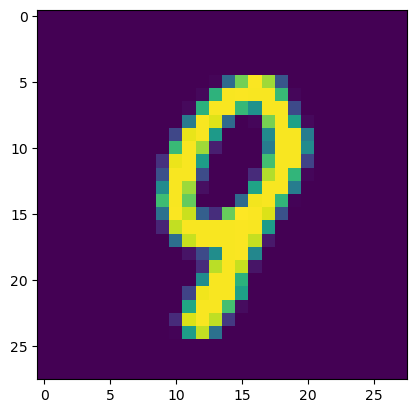

In [ ]:
fig, ax = plt.subplots(1, 1)

plot_single_digit(train_rest[random.randint(0, len(train_rest))], ax)

# example of a random sample

In [ ]:
def model0():
    model_0 = torch.nn.Sequential(
        torch.nn.Linear(784, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 32),
        torch.nn.ReLU(),
            
        torch.nn.Linear(32, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 784),
        torch.nn.Sigmoid()
    )

    return model_0.to(device=device())

def model1():
    model_1 = torch.nn.Sequential(
        torch.nn.Linear(784, 128),
        torch.nn.Tanh(),
        torch.nn.Linear(128, 64),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 32),
        torch.nn.Tanh(),
            
        torch.nn.Linear(32, 64),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 128),
        torch.nn.Tanh(),
        torch.nn.Linear(128, 784),
        torch.nn.Sigmoid()
    )

    return model_1.to(device=device())

def model2():
    model_2 = torch.nn.Sequential(
        torch.nn.Linear(784, 365),
        torch.nn.ReLU(),
        torch.nn.Linear(365, 64),
        torch.nn.ReLU(),
            
        torch.nn.Linear(64, 365),
        torch.nn.ReLU(),
        torch.nn.Linear(365, 784),
        torch.nn.Sigmoid()
    )

    return model_2.to(device=device())

def model3():
    model_3 = torch.nn.Sequential(
        torch.nn.Linear(784, 365),
        torch.nn.Tanh(),
        torch.nn.Linear(365, 64),
        torch.nn.Tanh(),
            
        torch.nn.Linear(64, 365),
        torch.nn.Tanh(),
        torch.nn.Linear(365, 784),
        torch.nn.Sigmoid()
    )

    return model_3.to(device=device())

def model4():
    model_4 = torch.nn.Sequential(
        torch.nn.Linear(784, 426),
        torch.nn.ReLU(),
        torch.nn.Linear(426, 128),
        torch.nn.ReLU(),
            
        torch.nn.Linear(128, 426),
        torch.nn.ReLU(),
        torch.nn.Linear(426, 784),
        torch.nn.Sigmoid()
    )

    return model_4.to(device=device())

def model5():
    model_5 = torch.nn.Sequential(
        torch.nn.Linear(784, 426),
        torch.nn.Tanh(),
        torch.nn.Linear(426, 128),
        torch.nn.Tanh(),
            
        torch.nn.Linear(128, 426),
        torch.nn.Tanh(),
        torch.nn.Linear(426, 784),
        torch.nn.Sigmoid()
    )

    return model_5.to(device=device())

# different types of model architectures

Text(0.5, 1.0, 'Untrained model loss: 0.223467')

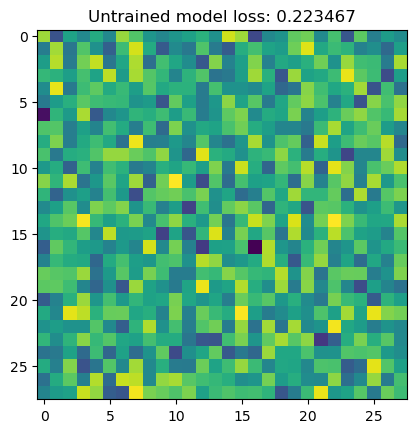

In [ ]:
fig, ax = plt.subplots(1, 1)

model = model0()

plot_single_digit(model(train_rest[0]), ax)
ax.set_title(f"Untrained model loss: {torch.nn.functional.mse_loss(model(train_rest[0]), train_rest[0]):.6f}")

# autoencoder before it is trained

In [ ]:
def train_autoencoder_model(data, model, hyperparams, plot_loss=False, print_epoch=False):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["learn_rate"], weight_decay=hyperparams["weight_decay"])

    loss_vals = []

    for epoche in range(hyperparams["max_epoches"]):
        optimizer.zero_grad()
        i = np.random.choice(data.shape[0], size=hyperparams["batch_size"], replace=False)
        batch_X = data[i]
        loss = torch.nn.functional.mse_loss(model(batch_X), batch_X)
        loss.backward()
        optimizer.step()
        
        loss_vals.append(loss.item())
        if epoche % 100 == 0 and print_epoch:
            print(f"Epoch {epoche}, Loss: {loss.item():.6f}")

    if plot_loss:
        plt.plot(range(hyperparams["max_epoches"]), loss_vals)
        plt.ylabel("loss")
        plt.xlabel("epoche")
        
# train a model given data parameters
# training by getting batches of random samples without replacement at each epoche

Epoch 0, Loss: 0.231140
Epoch 100, Loss: 0.229281
Epoch 200, Loss: 0.229196
Epoch 300, Loss: 0.229009
Epoch 400, Loss: 0.228985
Epoch 500, Loss: 0.229161
Epoch 600, Loss: 0.228913
Epoch 700, Loss: 0.228946
Epoch 800, Loss: 0.229168
Epoch 900, Loss: 0.229127


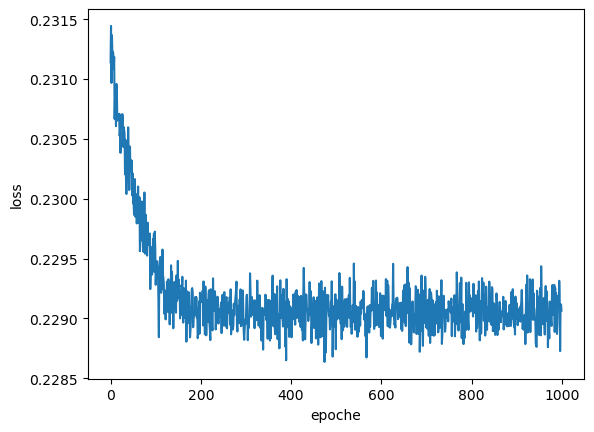

In [ ]:
model = model0()

train_autoencoder_model(train_rest, model, {"learn_rate": 0.001, "weight_decay": 0.02, "max_epoches": 1000, "batch_size": 1000}, plot_loss=True, print_epoch=True)

# bad paramaters lead to low learning

Text(0.5, 1.0, 'mean')

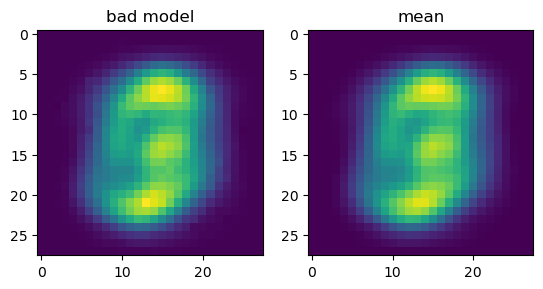

In [ ]:
fig, ax = plt.subplots(1, 2)

plot_single_digit(model(train_rest[0]), ax[0])
plot_single_digit(torch.mean(train_rest, axis=0), ax[1])
ax[0].set_title("bad model")
ax[1].set_title("mean")

# bad parameters given to the model can lead it to be stuck in a local optimum

Epoch 0, Loss: 0.231827
Epoch 100, Loss: 0.051478
Epoch 200, Loss: 0.036778
Epoch 300, Loss: 0.027331
Epoch 400, Loss: 0.024029
Epoch 500, Loss: 0.022338
Epoch 600, Loss: 0.021225
Epoch 700, Loss: 0.020166
Epoch 800, Loss: 0.017998
Epoch 900, Loss: 0.018483


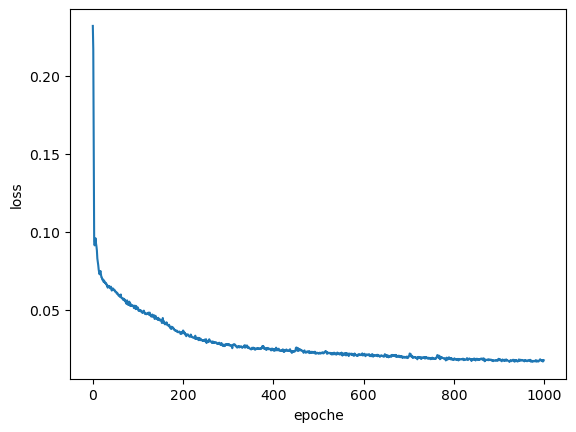

In [ ]:
model = model0()

train_autoencoder_model(train_rest, model, {"learn_rate": 0.01, "weight_decay": 0.0, "max_epoches": 1000, "batch_size": 1000}, plot_loss=True, print_epoch=True)

# example of how a model learns thorugh batch gradient descent

Text(0.5, 1.0, 'real')

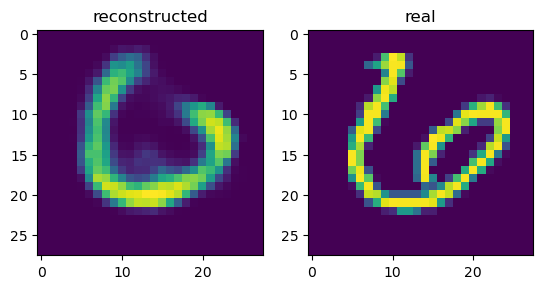

In [ ]:
fig, ax = plt.subplots(1, 2)

plot_single_digit(model(train_rest[0]), ax[0])
plot_single_digit(train_rest[0], ax[1])
ax[0].set_title("reconstructed")
ax[1].set_title("real")

# example of how a models hsould reconstruct a number

In [92]:
from itertools import product

# frid search to get best hyperparamaters
# getting the error on the 8 data and the rest of the data

hyperparams = {"learn_rate": [0.01, 0.001, 0.0001], "weight_decay": [0.0, 0.000000001], "max_epoches": [1500, 3000], "batch_size": [750, 5000]}
model_type = [model0(), model1(), model2(), model3(), model4(), model5()]

# for time saving i selected shorter ones which still perform good
hyperparams = {"learn_rate": [0.01, 0.001], "weight_decay": [0.0], "max_epoches": [1000], "batch_size": [750]}
model_type = [model0(), model1(), model2(), model3(), model4(), model5()]

keys = list(hyperparams.keys())
values = list(hyperparams.values())

combinations = list(product(*values))
all_configs = [dict(zip(keys, combo)) for combo in combinations]

models = np.empty((len(model_type), len(all_configs)), dtype=object)
eval_models = {}

for i, model in enumerate(model_type):
    for j, config in enumerate(all_configs):
        print(f"model {i, j}: hyperparamaters: {config}")
        train_autoencoder_model(train_rest, model, config)
        
        # evaluations on test_rest and test_8
        models[i, j] = model
        eval_models[(i, j)] = np.array([torch.nn.functional.mse_loss(model(eval_rest), eval_rest).item(),
                                        torch.nn.functional.mse_loss(model(eight_test), eight_test).item()])

model (0, 0): hyperparamaters: {'learn_rate': 0.01, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (0, 1): hyperparamaters: {'learn_rate': 0.001, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (1, 0): hyperparamaters: {'learn_rate': 0.01, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (1, 1): hyperparamaters: {'learn_rate': 0.001, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (2, 0): hyperparamaters: {'learn_rate': 0.01, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (2, 1): hyperparamaters: {'learn_rate': 0.001, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (3, 0): hyperparamaters: {'learn_rate': 0.01, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (3, 1): hyperparamaters: {'learn_rate': 0.001, 'weight_decay': 0.0, 'max_epoches': 1000, 'batch_size': 750}
model (4, 0): hyperparamaters: {'learn_rate': 0.01, 'weight_decay': 0.0, 'max_epoches': 1000

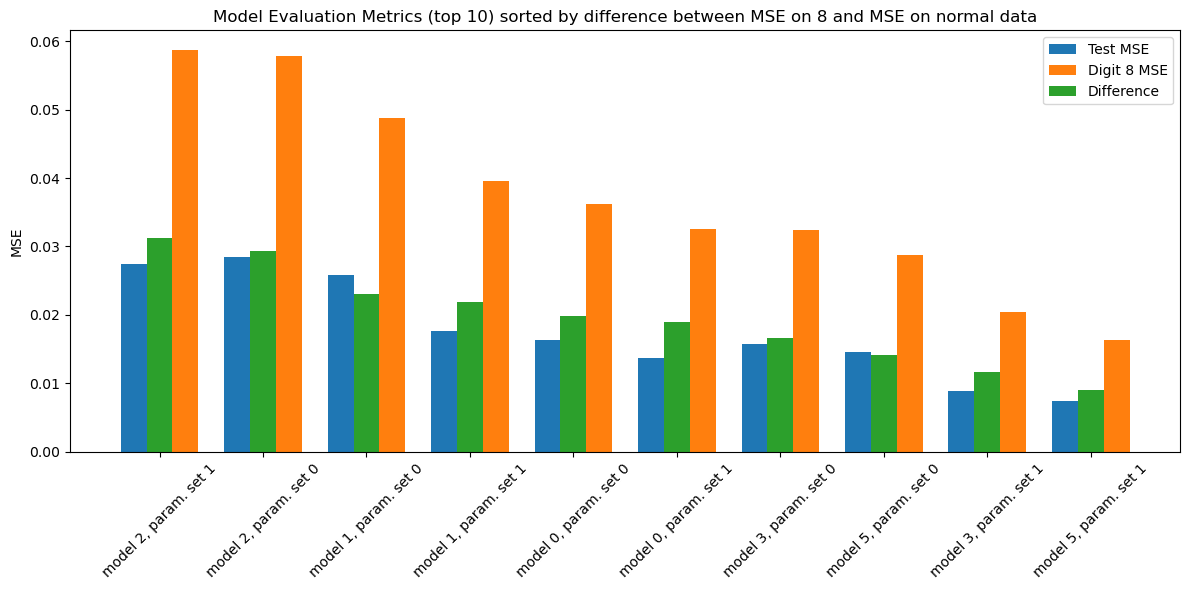

In [133]:
diff = np.abs(np.array(list(eval_models.values()))[:, 0] - np.array(list(eval_models.values()))[:, 1])
model_names = []
for model_name in list(eval_models.keys()):
    model_names.append(f"model {model_name[0]}, param. set {model_name[1]}")

n = len(diff)
if len(diff) > 10:
    n = 10

sorted_idx = np.argsort(-diff)

model_names = np.array(model_names)[sorted_idx][:n]
eval_vals = np.array(list(eval_models.values()))[sorted_idx][:n]
diff_vals = diff[sorted_idx][:n]

x = np.arange(n)
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, eval_vals[:, 0], width, label='Test MSE')
ax.bar(x + width, eval_vals[:, 1], width, label='Digit 8 MSE')
ax.bar(x, diff_vals, width, label='Difference')

ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylabel("MSE")
ax.set_title(f"Model Evaluation Metrics (top {n}) sorted by difference between MSE on 8 and MSE on normal data")
ax.legend()

plt.tight_layout()
plt.show()

best_model = models.reshape(-1, 1)[sorted_idx][0][0]

Text(0.87, 0.6, 'Untrained')

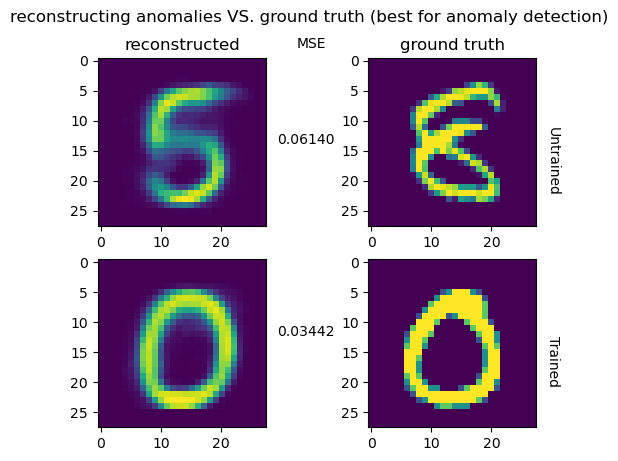

In [134]:
fig, ax = plt.subplots(2, 2)

fig.suptitle("reconstructing anomalies VS. ground truth (best for anomaly detection)")

rand_idx1 = random.randint(0, len(eval_rest))
rand_idx2 = random.randint(0, len(eight_test))

plot_single_digit(best_model(eight_test[rand_idx2]), ax[0, 0])
plot_single_digit(eight_test[rand_idx2], ax[0, 1])
plot_single_digit(best_model(eval_rest[rand_idx1]), ax[1, 0])
plot_single_digit(eval_rest[rand_idx1], ax[1, 1])
ax[0, 0].set_title("reconstructed")
ax[0, 1].set_title("ground truth")

fig.text(0.48, 0.9, "MSE")
fig.text(0.45, 0.7, f"{torch.nn.functional.mse_loss(best_model(eight_test[rand_idx2]), eight_test[rand_idx2]):.5f}")
fig.text(0.45, 0.3, f"{torch.nn.functional.mse_loss(best_model(eval_rest[rand_idx1]), eval_rest[rand_idx1]):.5f}")

fig.text(0.87, 0.2, "Trained", rotation=270)
fig.text(0.87, 0.6, "Untrained", rotation=270)

In [135]:
combined_eval_data = torch.concat((eight_test, eval_rest), dim=0)    # combine normal samples with the 4 test data
y_true = np.concatenate((np.ones(len(eight_test)), np.zeros(len(eval_rest))))

In [136]:
def get_MSE_loss(model, data):
    return torch.nn.functional.mse_loss(model(data), data, reduction="none").mean(dim=1).detach().cpu()

In [137]:
def predict_if_anomalous(data, model, threshold):
    with torch.no_grad():
        errors = get_MSE_loss(model, data)
    return (errors > threshold).cpu().numpy().astype(int)

# predict of a sample is anomalous or not given a data a model and a threshold

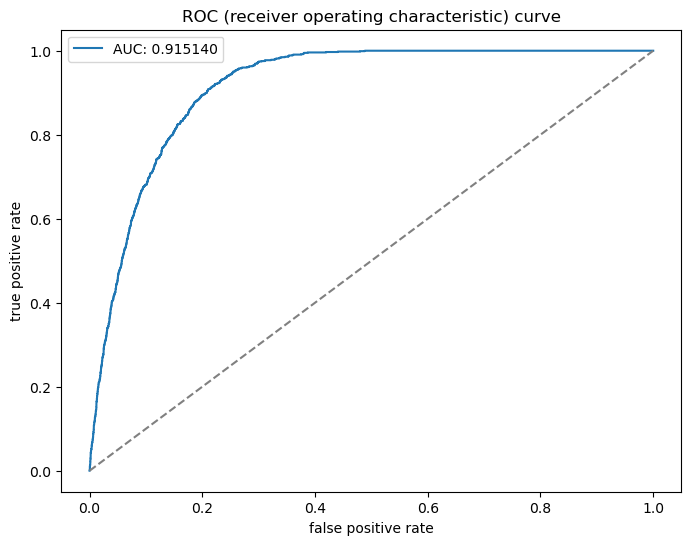

In [138]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, get_MSE_loss(best_model, combined_eval_data))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC: {roc_auc:.6f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC (receiver operating characteristic) curve')
plt.legend()

# the ROC curve doesnt take in consideration the inbalanced dataset

C:\Users\William\AppData\Local\Temp\ipykernel_109164\3042669383.py:11: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


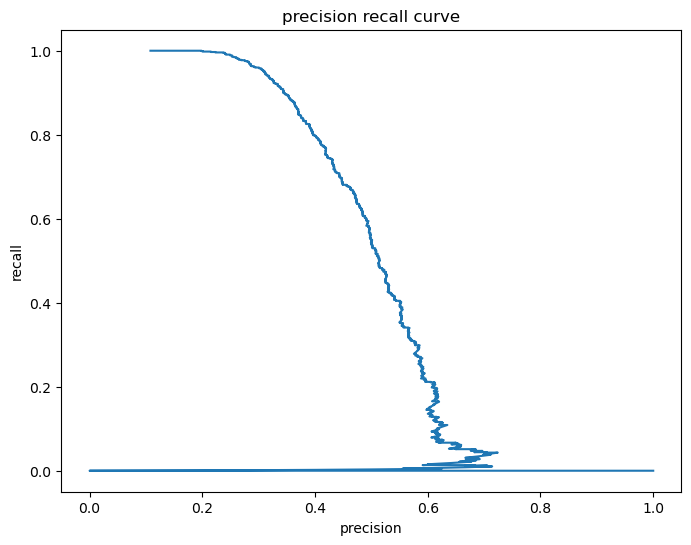

In [139]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_true, get_MSE_loss(best_model, combined_eval_data))

plt.figure(figsize=(8,6))
plt.plot(precisions, recalls)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('precision recall curve')

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = f1_scores.argmax()
best_f1_threshold = thresholds[best_idx]

distances = np.sqrt((1 - precisions)**2 + (1 - recalls)**2)
best_index = np.argmin(distances)

if best_index < len(thresholds):
    best_threshold = thresholds[best_index]
else:
    best_threshold = thresholds[-1]
    
# precision recall curve andd their thresholds for best model
# precision recall curve accounts for imbalances in the data

In [140]:
combined_test_data = torch.concat((four_test, test_rest), dim=0)    # combine normal samples with the 4 test data
y_true = np.concatenate((np.ones(len(four_test)), np.zeros(len(test_rest))))


accuracy: 0.850700
recall: 0.453157
precision: 0.297261
f1 score: 0.359016
      


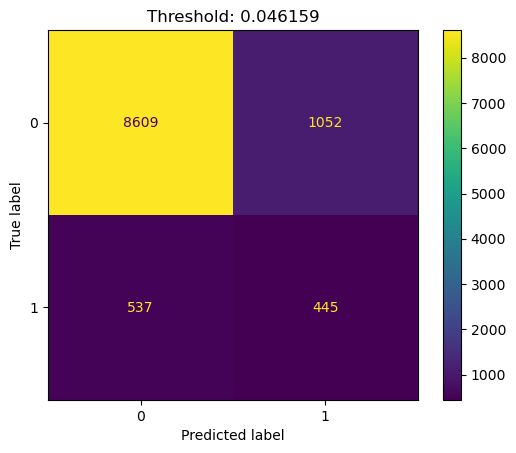

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, predict_if_anomalous(combined_test_data, best_model, best_threshold))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Threshold: {best_threshold:.6f}")

TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN) 
precision = TP / (TP + FP) 
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"""
accuracy: {accuracy:.6f}
recall: {recall:.6f}
precision: {precision:.6f}
f1 score: {f1_score:.6f}
      """)

# get confusion matrix of model closestr to optimal threshold

In [147]:
target_recall = 0.95 # for 8 data so it wont be the same for 4 data

valid_indices = np.where(recalls >= target_recall)[0]

if len(valid_indices) > 0:
    best_index = valid_indices[-1] 
    threshold_at_target_recall = thresholds[best_index]
    
recalls[best_index]

0.9507186858316222


accuracy: 0.740205
recall: 0.704684
precision: 0.218503
f1 score: 0.333574
      


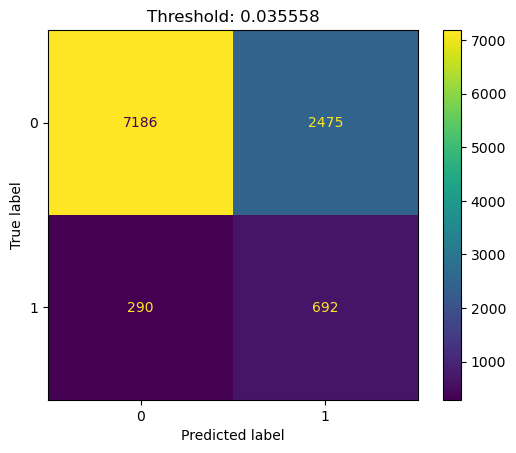

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, predict_if_anomalous(combined_test_data, best_model, threshold_at_target_recall))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Threshold: {threshold_at_target_recall:.6f}")

TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN) 
precision = TP / (TP + FP) 
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"""
accuracy: {accuracy:.6f}
recall: {recall:.6f}
precision: {precision:.6f}
f1 score: {f1_score:.6f}
      """)

# get confusion matrix of model with higher recall

In [ ]:
from sklearn.metrics import accuracy_score

high_diff_model = best_model
low_diff_model = models.reshape(-1, 1)[sorted_idx][n][0]

print(f"accuracy of high diff model on eval data: {accuracy_score(y_true, predict_if_anomalous(combined_test_data, high_diff_model, best_threshold)):.4f}")

precisions, recalls, thresholds = precision_recall_curve(y_true, get_MSE_loss(low_diff_model, combined_test_data))
distances = np.sqrt((1 - precisions)**2 + (1 - recalls)**2)
best_index = np.argmin(distances)

if best_index < len(thresholds):
    best_low_diff_threshold = thresholds[best_index]
else:
    best_low_diff_threshold = thresholds[-1]

print(f"accuracy of low diff model on eval data: {accuracy_score(y_true, predict_if_anomalous(combined_test_data, low_diff_model, best_low_diff_threshold)):.4f}")

# compare models with low and high difference in MSE between rest and 8 data for sanity check

accuracy of high diff model on eval data: 0.8507
accuracy of low diff model on eval data: 0.6602
